# Breast Cancer Image Segmantation 




### Introduction  
This project focuses on breast cancer image segmentation, with the primary goal of identifying and detecting cancerous regions from ultrasound images. The output of our model is a binary image (black and white), where cancerous areas are highlighted in white, and the non-cancerous regions are represented in black.  

### About the Dataset  
The dataset comprises medical images of breast cancer obtained through ultrasound scans. It is categorized into three classes: normal, benign, and malignant. Each class contains corresponding ultrasound images and their respective mask images. In the mask images, cancerous areas are marked in white, while normal regions are displayed in black, providing a clear distinction for segmentation t
nal details!

### Import Libraries 

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


### Data preprocessing 

In [2]:
root_dir = "Dataset_BUSI_with_GT"

In [3]:
folders = os.listdir(root_dir)
folders

['benign', 'malignant', 'normal']

In [4]:
folders = ["benign", "malignant", "normal"]

In [5]:
image_paths, labels, mask_paths = [], [], []

for folder in folders:
    files = os.listdir(os.path.join(root_dir, folder))
    for file in files:
        if "mask_" in file:
            continue
        elif "mask" in file:
            mask_paths.append(os.path.join(root_dir, folder, file))
        else:
            image_paths.append(os.path.join(root_dir, folder, file))
            labels.append(folder)

In [6]:
df = pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths,"label": labels})

In [7]:
df.head()

,image_path,mask_path,label
0,Dataset_BUSI_with_GT\benign\benign (1).png,Dataset_BUSI_with_GT\benign\benign (1)_mask.png,benign
1,Dataset_BUSI_with_GT\benign\benign (10).png,Dataset_BUSI_with_GT\benign\benign (10)_mask.png,benign
2,Dataset_BUSI_with_GT\benign\benign (100).png,Dataset_BUSI_with_GT\benign\benign (100)_mask.png,benign
3,Dataset_BUSI_with_GT\benign\benign (101).png,Dataset_BUSI_with_GT\benign\benign (101)_mask.png,benign
4,Dataset_BUSI_with_GT\benign\benign (102).png,Dataset_BUSI_with_GT\benign\benign (102)_mask.png,benign


In [8]:
df["label"].value_counts()

benign       437
malignant    210
normal       133
Name: label, dtype: int64

#### Normalize Image and convert To NumPy Array 

The following function is designed to preprocess an image from a specified file path and return it as a normalized NumPy array suitable for input into a machine learning model.

In [9]:
def load_image(path):
    img = load_img(path, target_size=(128, 128), color_mode='grayscale')
    image_array = img_to_array(img)
    image_array /= 255.
    return image_array

In [10]:
images = []
masks = []

for image_path, mask_path in tqdm(zip(image_paths, mask_paths)):
    image = load_image(image_path)
    images.append(image)

    mask = load_image(mask_path)
    masks.append(mask)

780it [00:24, 31.69it/s]


#### Data Visualisation 

In [11]:
images = np.array(images)
masks = np.array(masks)

In [28]:
def plot_image_and_mask(images, masks):
    plt.figure(figsize=(20, 6))

    for i in range(8):
        idx = np.random.randint(len(images))
        plt.subplot(3, 8, i + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Ultrasound")

        plt.subplot(3, 8, i + 9)
        plt.imshow(masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Mask")

    plt.show()

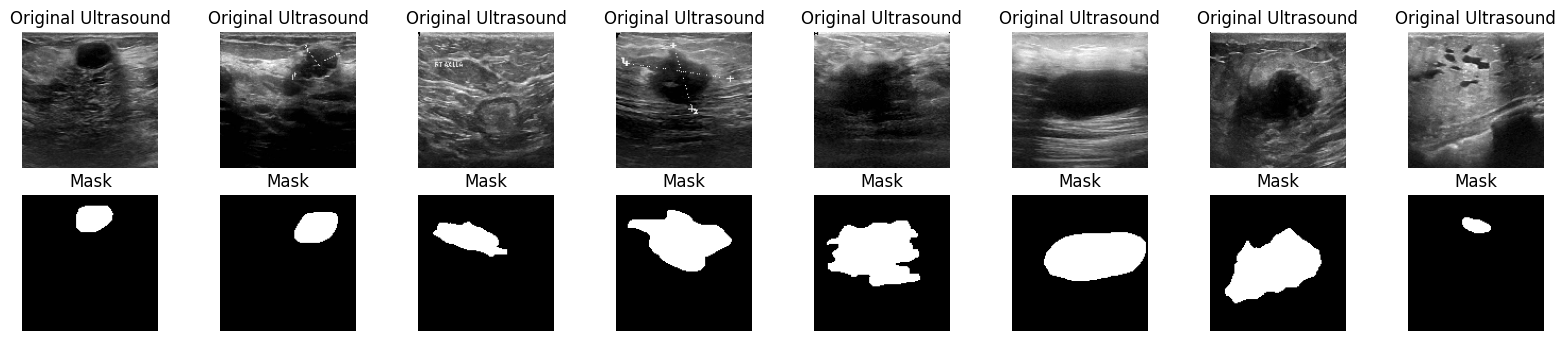

In [29]:
plot_image_and_mask(images, masks)

#### Splitting the Dataset

In [14]:
images = images[:-133]
masks = masks[:-133]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)

### Define The Model 

#### **What is U-Net ?**
U-Net is a deep learning architecture specifically designed for **semantic segmentation**, where the goal is to assign a class label to each pixel in an image. Originally developed for **biomedical image segmentation**, U-Net has proven to be highly effective across various domains, including medical imaging, satellite image analysis, and document processing.  

The architecture was introduced in the paper **"U-Net: Convolutional Networks for Biomedical Image Segmentation"** by Ronneberger et al. in 2015. Its unique design enables precise localization while maintaining global context, making it particularly suitable for tasks requiring pixel-level accuracy.



on of its architecture or an illustration of its workflow?

#### **Key Features of U-Net**  
1. Symmetrical Architecture
   - U-Net has a U-shaped architecture consisting of two main parts:  
     - **Encoder :** Captures the context and extracts features from the input image using convolutional and max-pooling layers.  
     - **Decoder :** Reconstructs the segmentation map using upsampling layers and skip connections.

2. **Skip Connections**  
   - Skip connections link the encoder and decoder paths, transferring spatial information from the contracting path to the expanding path.  
   - This helps preserve fine-grained details that might otherwise be lost during downsampling.

3. **Fully Convolutional Network (FCN)**  
   - U-Net uses only convolutional layers, avoiding fully connected layers, which allows it to process images of variable sizes.

4. **End-to-End Training**  
   - The network is trained end-to-end, directly optimizing for segmentation accuracy.

In [16]:
def conv_block(input_layer, num_filters, drop_rate):
    conv = layers.Conv2D(num_filters, (3, 3), activation="elu", padding="same", kernel_initializer="he_normal")(input_layer)
    conv = layers.Dropout((drop_rate))(conv)
    conv = layers.Conv2D(num_filters, (3, 3), activation="elu", padding="same", kernel_initializer="he_normal")(conv)
    return conv

In [17]:
def encoder_block(input_layer, num_filters, drop_rate):
    conv = conv_block(input_layer, num_filters, drop_rate)
    maxp = layers.MaxPooling2D((2, 2))(conv)
    return conv, maxp

In [18]:
def decoder_block(input_layer, skip_features, drop_rate, num_filters):
    convt = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_layer)
    cnt = layers.concatenate([convt, skip_features])
    conv = conv_block(cnt, num_filters, drop_rate)
    return conv

In [19]:
input_layer = layers.Input(shape=(128, 128, 1))

s1, p1 = encoder_block(input_layer, 32, 0.1)
s2, p2 = encoder_block(p1, 64, 0.1)
s3, p3 = encoder_block(p2, 128, 0.2)
s4, p4 = encoder_block(p3, 256, 0.2)
s5, p5 = encoder_block(p4, 512, 0.3)

bottle = conv_block(p5, 1024, 0.3)

d1 = decoder_block(bottle, s5, 0.3, 512)
d2 = decoder_block(d1, s4, 0.2, 256)
d3 = decoder_block(d2, s3, 0.2, 128)
d4 = decoder_block(d3, s2, 0.1, 64)
d5 = decoder_block(d4, s1, 0.1, 32)

output_layer = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

model = models.Model(input_layer, output_layer)

### Training 

In [20]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7638 - loss: 0.5890 - val_accuracy: 0.9108 - val_loss: 0.2450
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8964 - loss: 0.2937 - val_accuracy: 0.9125 - val_loss: 0.2292
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9054 - loss: 0.2494 - val_accuracy: 0.9175 - val_loss: 0.2260
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9167 - loss: 0.2189 - val_accuracy: 0.9263 - val_loss: 0.2178
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9099 - loss: 0.2269 - val_accuracy: 0.9213 - val_loss: 0.2114
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9207 - loss: 0.2083 - val_accuracy: 0.9252 - val_loss: 0.2123
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9196 - loss: 0.2129 - val_accuracy: 0.9188 - val_loss: 0.2198
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9170 - loss: 0.2134 - val_accuracy: 0.9267 - val_loss:

In [22]:
history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.853899,0.431602,0.910795,0.244991
1,0.905450,0.269229,0.912527,0.229155
2,0.909808,0.238992,0.917532,0.226029
3,0.916481,0.219554,0.926335,0.217762
4,0.915268,0.219057,0.921253,0.211404


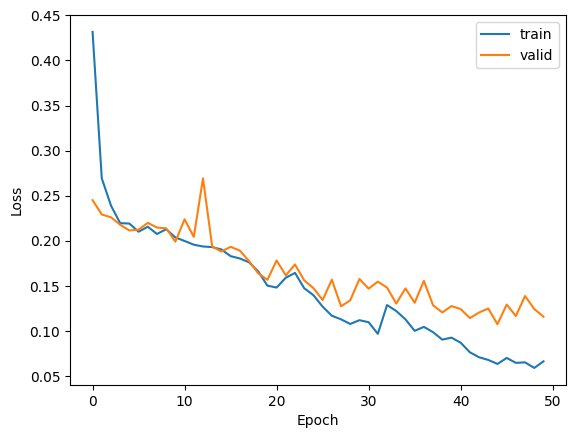

In [23]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

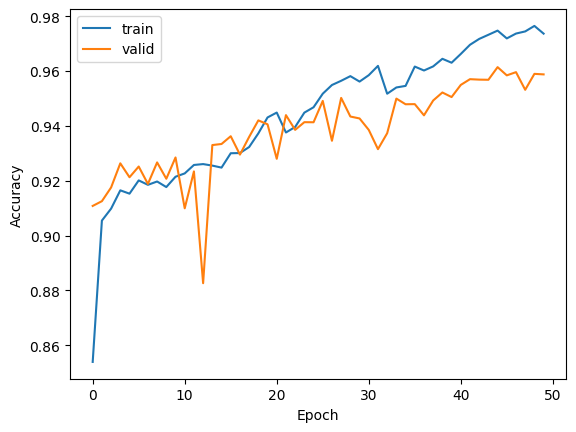

In [24]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

### Inference 

In [25]:
preds = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step


In [26]:
def plot_predictions(preds):
    plt.figure(figsize=(20, 6))

    for i in range(8):
        idx = np.random.randint(len(preds))
        plt.subplot(3, 8, i + 1)
        plt.imshow(X_test[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(3, 8, i + 9)
        plt.imshow(y_test[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(3, 8, i + 17)
        plt.imshow(preds[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")

    plt.show()

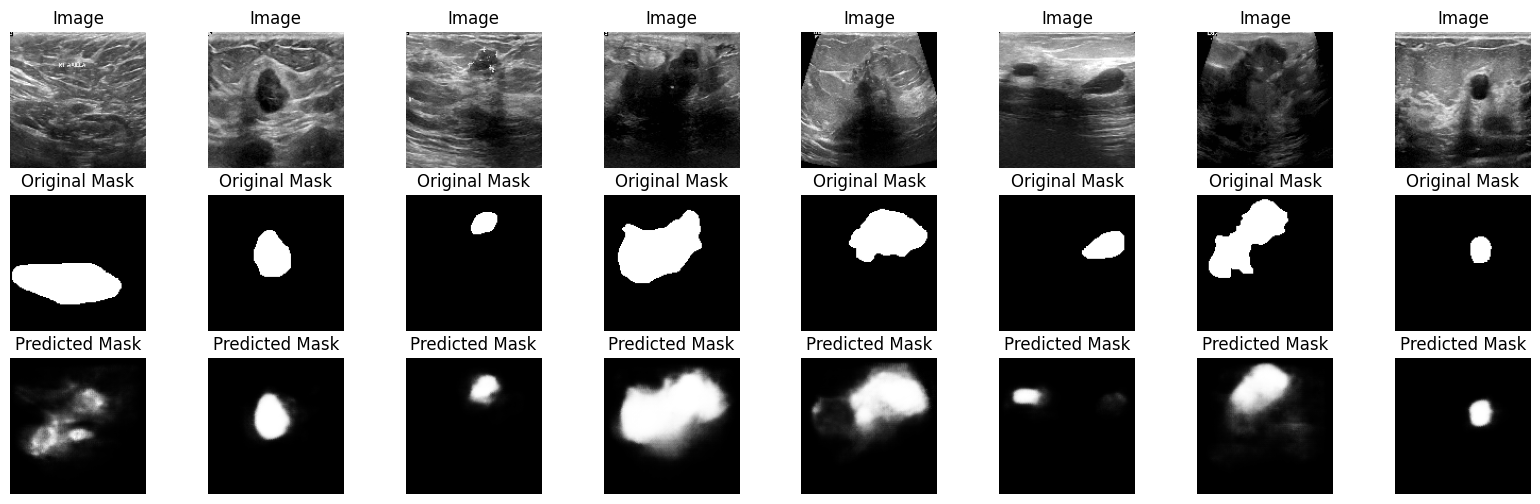

In [27]:
plot_predictions(preds)